## Layered Sigma Clipping, Part 1
-------
Created by Dr. Taylor Hutchison, NASA GSFC,  
on behalf of the TEMPLATES team.


This is the first step in the sigma clipping part of the algorithm described in H+, section 2.2.1.  In this step, we sigma clip only the sky (i.e., NOT science target) spaxels in the IFU cube, saving the output to its own FITS file to be read in at the final step.

In [1]:
from routines import * # helper functions & the needed imports

### Defining values

Below, we'll set some predefined information for the science target.

In [2]:
# --------------------------
# SCIENCE TARGET INFORMATION
# --------------------------
target = 'SGAS1723' # science target name

# returns dictionary of info for chosen science target
# also path to reduced FITS cubes to read in
science_target, path, grating = get_target_info(target)

# target-specific information
filename = science_target['grating'][grating]['filename']
sli = science_target['grating'][grating]['slice-sky'] # benchmark slice index (diff than part 2)


# for the sigma clipping part
# ---------------------------
sigma = 5
maxiters = 5


In [3]:
# defining a save path for the output data
# savepath = 'path/to/outputs'
savepath = 'plots-data/'


# checking if savepath locatiion existis
# if not, creating the folder 
if os.path.exists(savepath) == False: # if folder doesn't exist
    print('Creating folder ' + savepath)
    os.system('mkdir ' + savepath) # creates the folder

In [4]:
# ---------------------
# reading in data cubes
# ---------------------
datacube, header = fits.getdata(path+filename, header=True) 
errorcube = fits.getdata(path+filename, ext=2) 

benchmark_slice = datacube[sli]

### Defining the benchmark spaxels

Here we'll define the four spaxels that we'll reference throughout this notebook.  You can pre-identify these spaxels by inspecting the data cube using a software like ds9 (however, if you do this, recall that ds9 indexes beginning at 1 while python beings at 0).

Feel free to re-run the following cell over again as you change the spaxel coordinates, until you find four that you like.

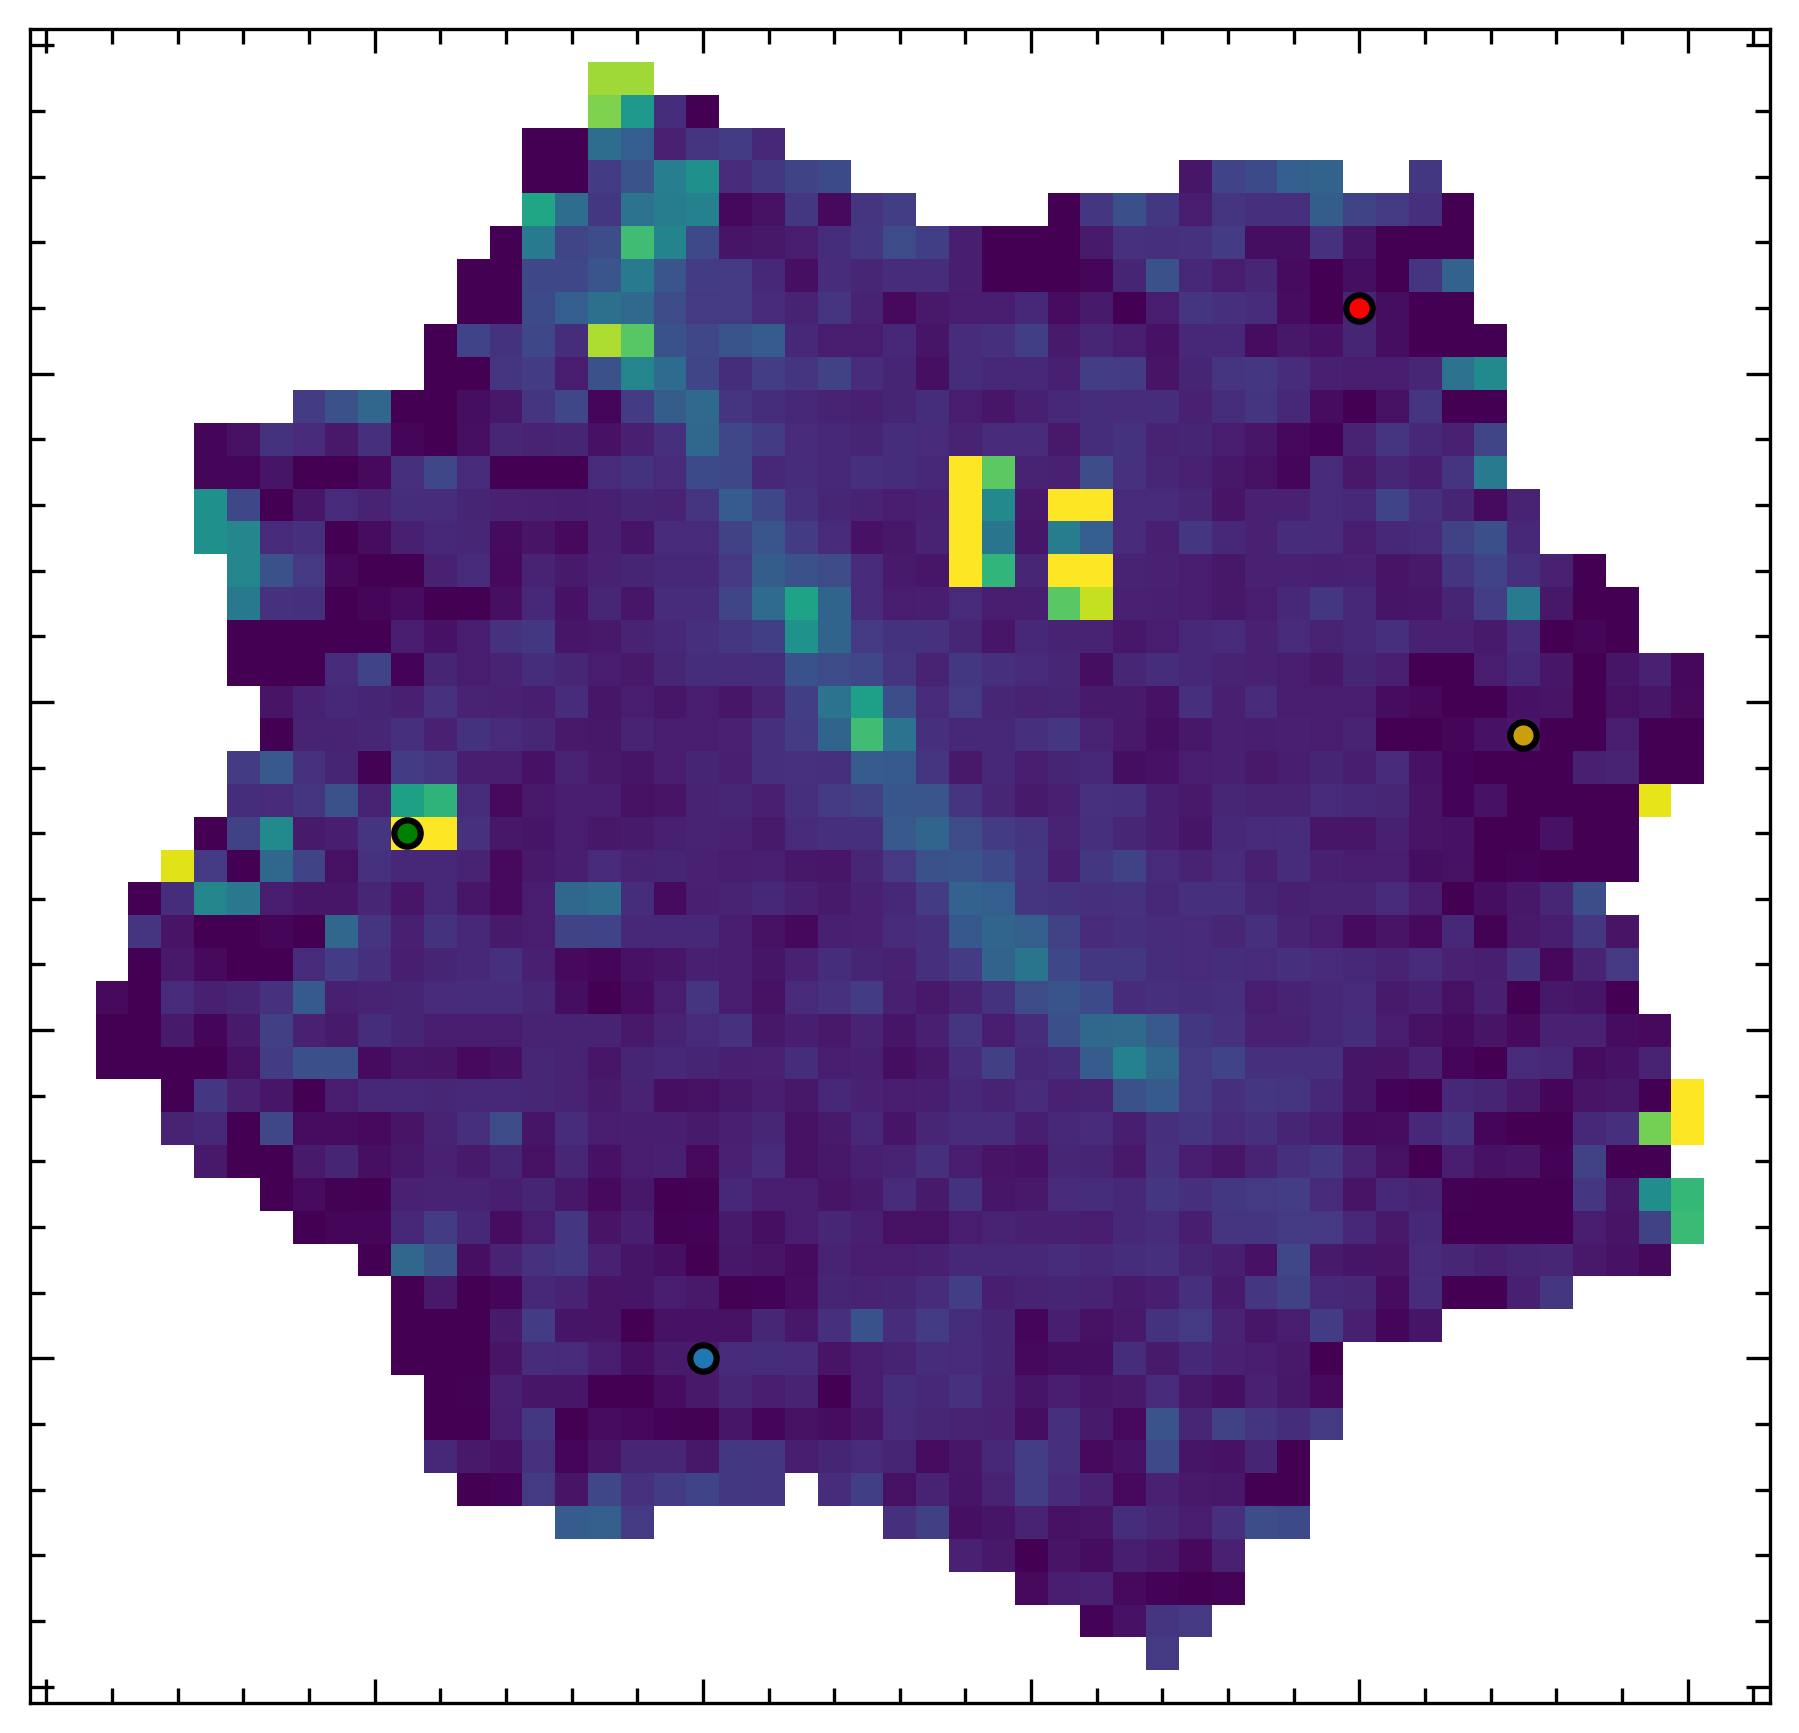

In [5]:
# identifying benchmark spaxels to look at throughout the sigma clipping process

x,y = 20,10 # spaxel 1, make this one "normal" in the benchmark slice
x2,y2 = 11,26 # spaxel 2
x3,y3 = 45,29 # spaxel 3
x4,y4 = 40,42 # spaxle 4


# LOOKING AT THE BENCHMARK SLICE & LOCATION OF 
# BENCHMARK SPAXELS CHOSEN ABOVE
# ---------------

# defining the colormap limits here, will use throughout notebook
clims = (-0.5,5)


plt.figure(figsize=(8,6))

plt.imshow(benchmark_slice,clim=clims,origin='lower',cmap='viridis')

plt.scatter(x,y,s=40,edgecolor='k',color='C0',lw=1.5) # "normal" spaxel
plt.scatter(x2,y2,s=40,edgecolor='k',color='g',lw=1.5) # spaxel 2
plt.scatter(x3,y3,s=40,edgecolor='k',color='#CB9E0E',lw=1.5) # spaxel 3
plt.scatter(x4,y4,s=40,edgecolor='k',color='r',lw=1.5) # spaxel 4

plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.tight_layout()
plt.show()
plt.close('all')


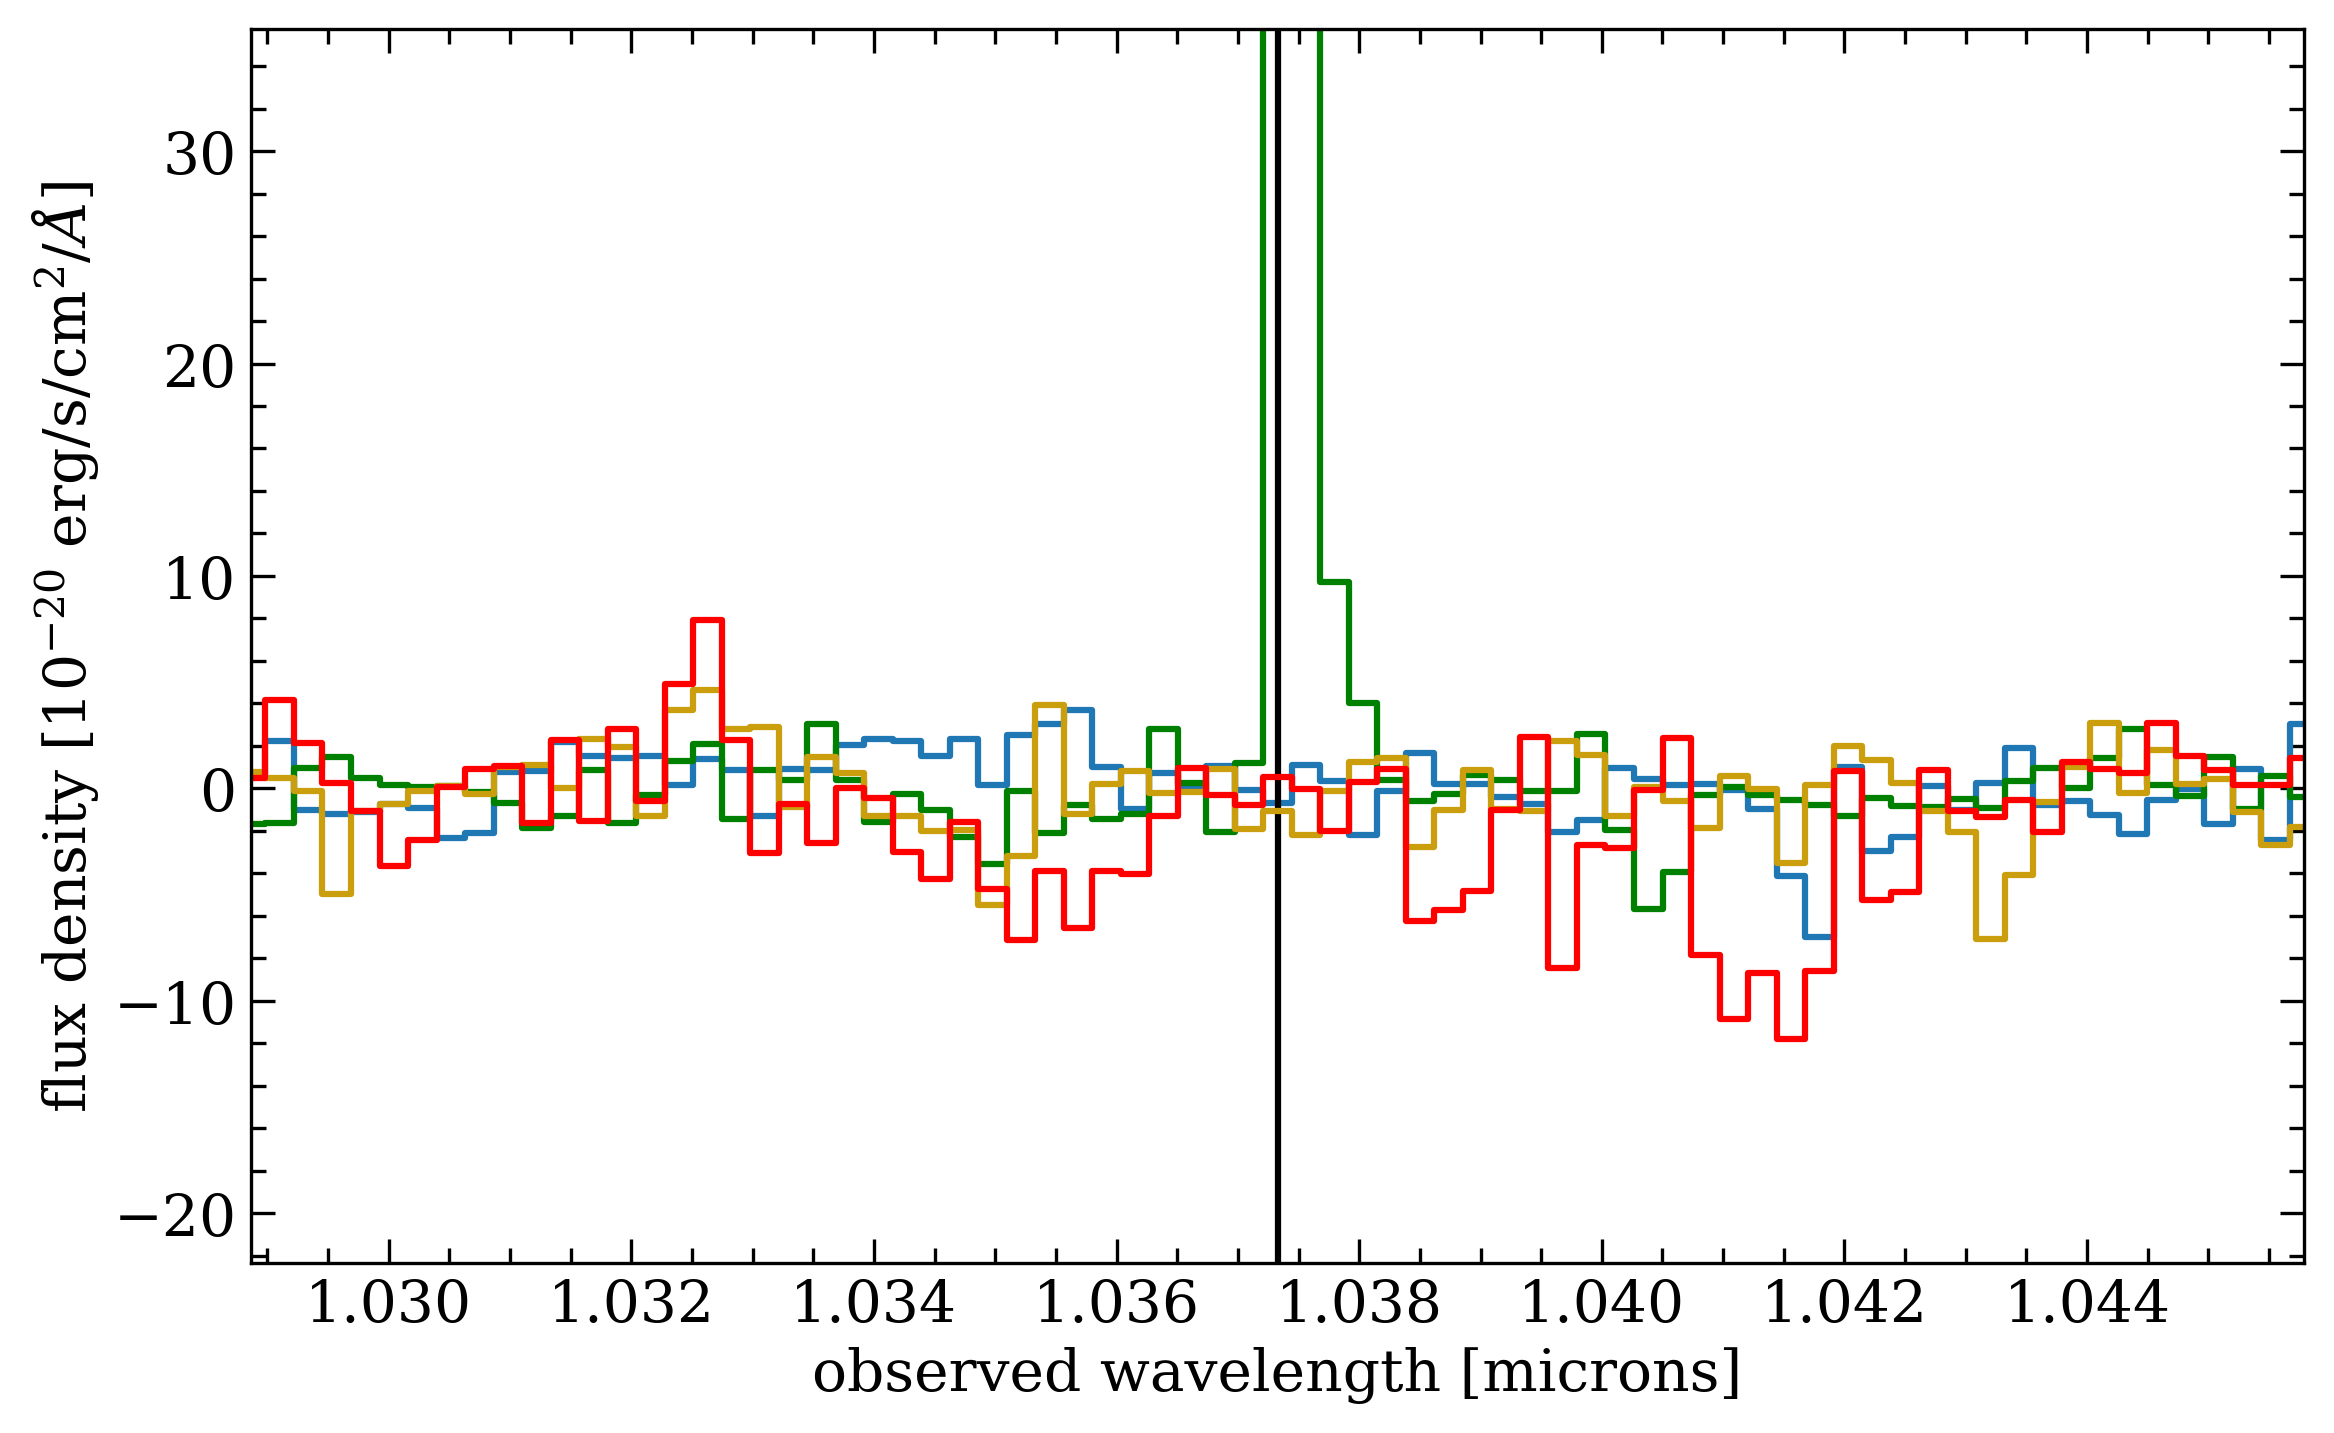

In [6]:
# ------------------------------------------
# LOOKING AT 1D AROUND BENCHMARK SLICE IN 1D
# ------------------------------------------

wave_mask = get_benchmark_wave_index(datacube,sli,header) # indicies around benchmark slice

# pulling spectrum at each benchmark spaxel
spec = get_spec(x,y,datacube,errorcube,header)
spec2 = get_spec(x2,y2,datacube,errorcube,header)
spec3 = get_spec(x3,y3,datacube,errorcube,header)
spec4 = get_spec(x4,y4,datacube,errorcube,header)

scale = get_yaxis_scaling(spec.flam.values) # to scale yaxis for readability
benchmark_wave = spec.loc[sli,'wave'] # to mark the benchmark slice in 1D

plt.figure(figsize=(8,5))

plt.step(spec.wave,spec.flam/scale,where='mid')
plt.axvline(benchmark_wave,color='k')

plt.step(spec2.wave,spec2.flam/scale,where='mid',color='g')
plt.step(spec3.wave,spec3.flam/scale,where='mid',color='#CB9E0E')
plt.step(spec4.wave,spec4.flam/scale,where='mid',color='r')

plt.xlim(spec.loc[wave_mask[0],'wave'],spec.loc[wave_mask[-1],'wave'])
plt.xlabel('observed wavelength [microns]')
plt.ylabel('flux density [10$^{%s}$ erg/s/cm$^2$/$\AA$]'%int(np.log10(scale)))

# roughhand setting of ylimits to not be biased by false signal;
# so that real features are visible in this validation check
y_scale = abs(np.nanmean([spec2.median().flam,spec3.median().flam,spec4.median().flam]) / scale)
plt.ylim(-50*y_scale,80*y_scale)


plt.tight_layout()
plt.show()
plt.close('all')


<div class="alert alert-success">
    We'll lean on the before and after spectra of the benchmark spaxels to check that the code is functioning as it should. 
</div>

### Reading in mask information

For this step in the layered sigma clipping algorithm, as we're focused on the sky (i.e., NOT science target) spaxels, we'll just use the main mask that simply defines if a spaxel is associated with the science target or not.

In [7]:
mask, mask_info = get_mask(target)
full_mask = mask[0].copy() # first entry is the full mask, rest are the layers

masked_benchmark_slice = benchmark_slice.copy()
masked_benchmark_slice[full_mask>0] = np.nan

### Initial sigma clipping test using benchmark slice

Here we'll run the clipping on just the benchmark slice, before moving to running it on every slice in the cube.  The left panel is the original benchmark slice, while the right panel is the same slice after clipping.  Any pixels flagged in the clipping will be NaNs (white).

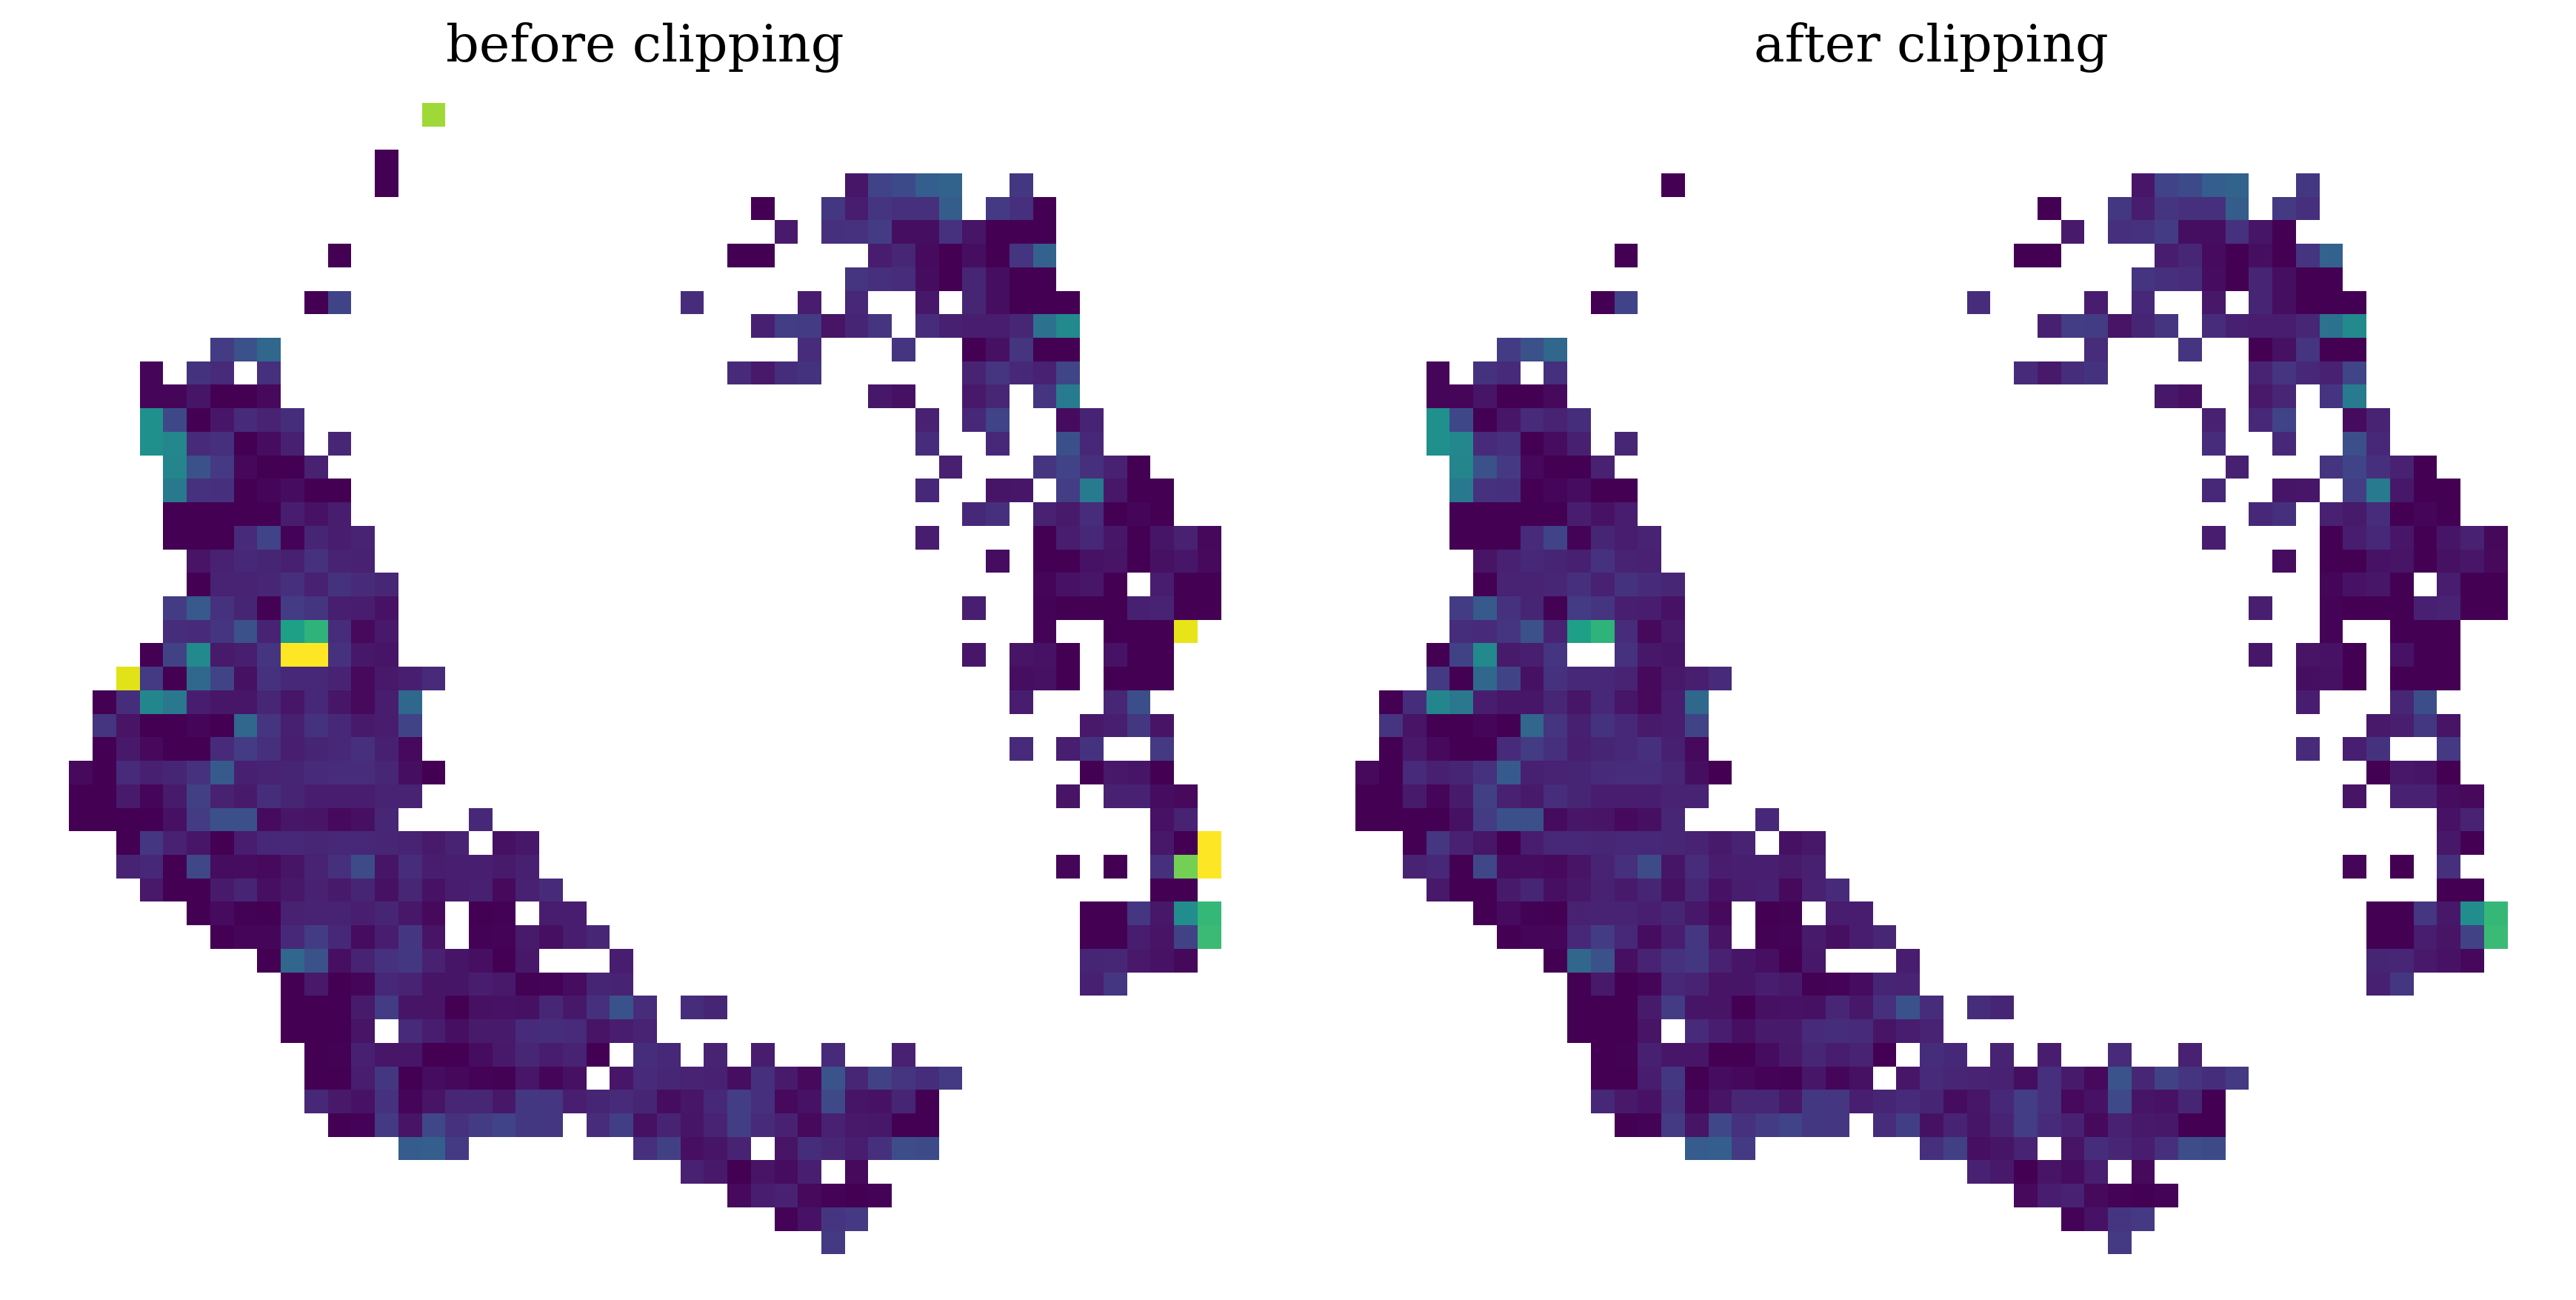

In [8]:
# sigma clipping masked slice
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    clipped_benchmark_slice = sigma_clip(masked_benchmark_slice, sigma=sigma, maxiters=maxiters)


# plotting clipped benchmark slice
# --------------------------------

plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,2,width_ratios=[1,1],wspace=0)

ax = plt.subplot(gs[0]); ax.axis('off'); ax.set_title('before clipping')
ax.imshow(masked_benchmark_slice,clim=clims,origin='lower',cmap='viridis')

ax = plt.subplot(gs[1]); ax.axis('off'); ax.set_title('after clipping')
ax.imshow(clipped_benchmark_slice,clim=clims,origin='lower',cmap='viridis')


plt.tight_layout()
plt.show()
plt.close('all')


### Running on the full cube

Assuming nothing went horribly wrong with the previous step, we'll move to running this clipping procedure on the entire cube, for all of the sky (i.e., NOT science target) spaxels.

In [9]:
# ----------------------
# RUNNING SLICE-BY-SLICE
# ----------------------

# making cube of zeros to log when a pixel has been clipped
# will be 1 in slice if pixel is clipped
clipped_pixels = np.zeros(datacube.shape)

# copy of original cube & error
data_clipped = datacube.copy()
error_clipped = errorcube.copy()


for i in range(len(data_clipped)):
    data_slice = datacube[i].copy()
    error_slice = errorcube[i].copy()

    # first, masking out galaxy spaxels
    data_slice[full_mask>0] = np.nan
    error_slice[full_mask>0] = np.nan
    
    mask_data_slice = data_slice.copy()
    mask_error_slice = error_slice.copy()
    
    # marking the pixels that were nans before
    # due to rotation of IFU based on observing PA
    nans_before = np.zeros(mask_data_slice.shape)
    nans_before[np.isnan(mask_data_slice) == True] = 1
    
    # first checking for the all-NaN slices in IFU
    # if yes, nothing happens for that slice and it just
    # gets added to the final cube as is
    # (this check is a holdover from earlier jwst pipeline versions)
    if np.isnan(mask_data_slice).all() == False:
        # sigma clipping
        with warnings.catch_warnings():  # Ignore warnings
            warnings.simplefilter('ignore')

            clip_mask = sigma_clip(mask_data_slice, sigma=sigma, maxiters=maxiters).mask

        clip_mask[full_mask>0] = False # re-masking out the science target

        # replaced flagged things with nanmedian 
        mask_data_slice[clip_mask] = np.nanmedian(mask_data_slice)
        mask_error_slice[clip_mask] = np.nanmedian(mask_error_slice)
    
        
        # logging pixels that were clipped in separate cube
        clipped_pixels[i][clip_mask] = 1
        # removing pixels that were NaNs before
        clipped_pixels[i][nans_before == 1] = 0
        
    
        # adding back in nans that were there before
        mask_data_slice[nans_before == 1] = np.nan
        mask_error_slice[nans_before == 1] = np.nan
    
    
    # adding back into cube
    data_clipped[i] = mask_data_slice.copy()
    error_clipped[i] = mask_error_slice.copy()
    
    
# verifying everything has the dimensions that they should at the end
print(datacube.shape,data_clipped.shape)

(3915, 51, 53) (3915, 51, 53)


### Checking changes in benchmark spaxels

As mentioned above, use the following plot of the benchmark spaxels' spectra to compare the before & after of the clipping process.  For this particular step in the algorithm, generally there aren't any issues, but it's always good to check!

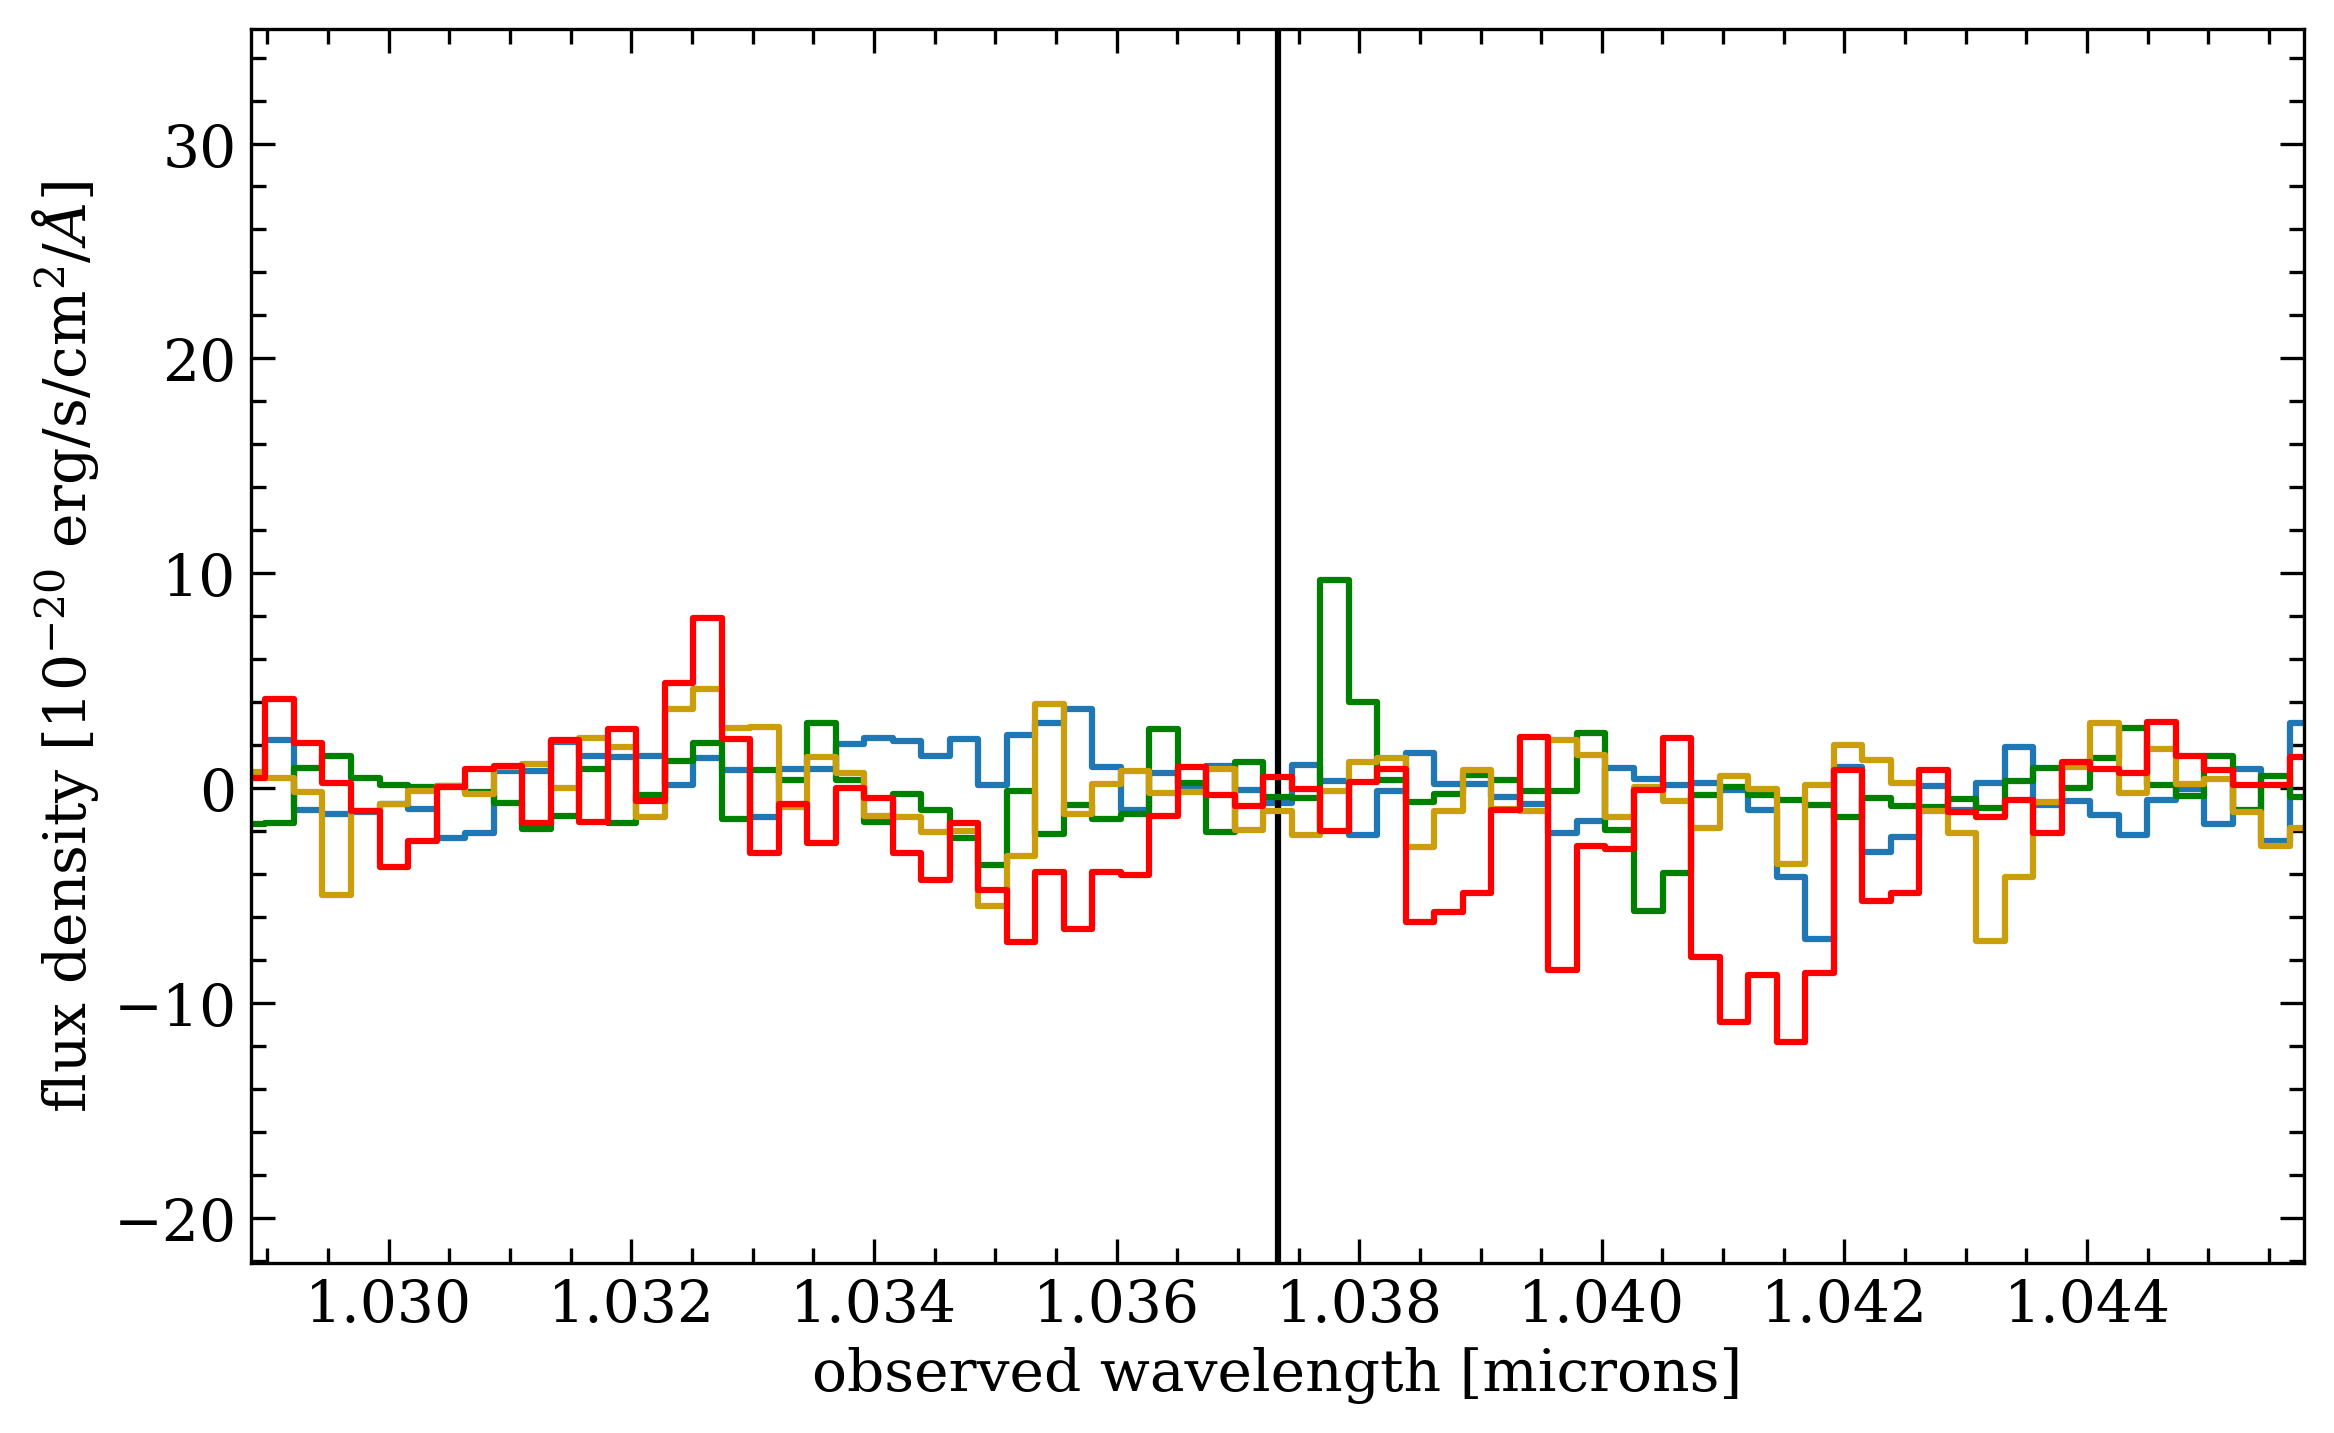

In [10]:
# ------------------------------------------
# LOOKING AT 1D AROUND BENCHMARK SLICE IN 1D
# ------------------------------------------

wave_mask = get_benchmark_wave_index(datacube,sli,header) # indicies around benchmark slice

# pulling spectrum at each benchmark spaxel, in clipped data & error cubes
spec = get_spec(x,y,data_clipped,error_clipped,header)
spec2 = get_spec(x2,y2,data_clipped,error_clipped,header)
spec3 = get_spec(x3,y3,data_clipped,error_clipped,header)
spec4 = get_spec(x4,y4,data_clipped,error_clipped,header)

scale = get_yaxis_scaling(spec.flam.values) # to scale yaxis for readability
benchmark_wave = spec.loc[sli,'wave'] # to mark the benchmark slice in 1D

plt.figure(figsize=(8,5))

plt.step(spec.wave,spec.flam/scale,where='mid')
plt.axvline(benchmark_wave,color='k')

plt.step(spec2.wave,spec2.flam/scale,where='mid',color='g')
plt.step(spec3.wave,spec3.flam/scale,where='mid',color='#CB9E0E')
plt.step(spec4.wave,spec4.flam/scale,where='mid',color='r')

plt.xlim(spec.loc[wave_mask[0],'wave'],spec.loc[wave_mask[-1],'wave'])
plt.xlabel('observed wavelength [microns]')
plt.ylabel('flux density [10$^{%s}$ erg/s/cm$^2$/$\AA$]'%int(np.log10(scale)))

# roughhand setting of ylimits to not be biased by false signal;
# so that real features are visible in this validation check
y_scale = abs(np.nanmean([spec2.median().flam,spec3.median().flam,spec4.median().flam]) / scale)
plt.ylim(-50*y_scale,80*y_scale)


plt.tight_layout()
plt.show()
plt.close('all')


### Saving outputs!

As we're running this algorithm piecewise -- first the sky spaxels in this notebook, then the science target spaxels in the next notebook -- we'll save the outputs from this notebook in a subfolder.  If it doesn't exit yet, no worries!  We'll make the subfolder, too.

In [11]:
# checking that the file system is in place for these data
# if not, creating the folder for saving the part 1 & part 2 pieces

if os.path.exists(savepath + 'sigma-clipping-pieces/') == False: # if folder doesn't exist
    print('Creating folder '+ savepath + 'sigma-clipping-pieces/')
    os.system('mkdir '+ savepath + 'sigma-clipping-pieces/') # creates the folder

For now, we're using a quick-and-dirty method to preserve the important header info -- copying the original header to these new cubes that we're saving and adding a comment.  This will be updated to a more accurate header in later versions.

In [12]:
header['comment'] = 'sky spaxels sigma-clipped by H+ algorithm'

pieces_path = savepath + 'sigma-clipping-pieces/'

hdu = fits.PrimaryHDU(header=header)
hdu1 = fits.ImageHDU(data_clipped,header=header) # the data cube
hdu2 = fits.ImageHDU(error_clipped,header=header) # the error cube
hdu3 = fits.ImageHDU(clipped_pixels,header=header) # the clipped pixels logging
hdul = fits.HDUList([hdu, hdu1, hdu2, hdu3])
hdul.writeto(f'{pieces_path}/{target}-sigmaclipping-sky-{grating}-s3d.fits',overwrite=True)


.  
.  
.  
### Great!  Now let's move to part 2...